# Feature extraction


## Install Packages

In [1]:
%%capture
!pip install forgi
!yes Y |conda install -c bioconda viennarna

## Library Imports

In [2]:
import os, math, random
from collections import Counter

import RNA
import subprocess
from forgi.graph import bulge_graph
import forgi.visual.mplotlib as fvm
from IPython.display import Image, SVG

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from colorama import Fore, Back, Style

## Data Import

In [3]:
path = '/kaggle/input/stanford-covid-vaccine'
train_df = pd.read_json(f'{path}/train.json',lines=True)
test_df = pd.read_json(f'{path}/test.json', lines=True)
sub_df = pd.read_csv(f'{path}/sample_submission.csv')

print('Train set sequences: ', train_df.shape)
print('Test set sequences: ', test_df.shape)

Train set sequences:  (2400, 19)
Test set sequences:  (3634, 7)


## Train Data Overview

In [4]:
train_df.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


## Test Data Overview

In [5]:
test_df.head()

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


## New Feature Overview

In [6]:
Select_id = "id_001f94081"

In [7]:
Sequence = train_df[train_df['id'] == Select_id]["sequence"].values[0]
structure = train_df[train_df['id'] == Select_id]["structure"].values[0]
predicted_loop_type = train_df[train_df['id'] == Select_id]["predicted_loop_type"].values[0]
bg, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + Sequence + '\n' + structure)
print("Sequence :",Sequence)
print("Structure :",structure)
print("Predicted Loop type :",predicted_loop_type)
print("Generated Loop type :", bg.to_element_string())

Sequence : GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC
Structure : .....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................
Predicted Loop type : EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHHHSSSSSSIISSIIIIISSXXXXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE
Generated Loop type : fffffsssssshhhhhhhssssissmssiiiiissiisssssshhhhssssssiissiiiiissmmmmssssssshhhhsssssssttttttttttttttttttttt


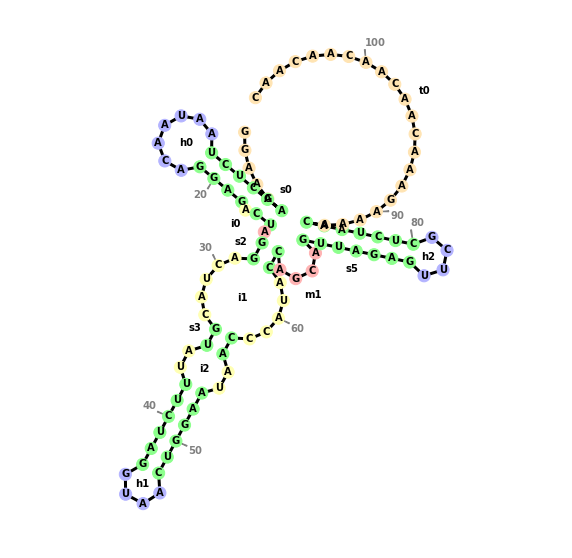

In [8]:
plt.figure(figsize=(10,10))
fvm.plot_rna(bg, text_kwargs={"fontweight":"black"}, lighten=0.7,
             backbone_kwargs={"linewidth":3})
plt.show()

## Generating Graph Matrices from the Structures
   * [Referance](https://www.kaggle.com/theoviel/generating-graph-matrices-from-the-structures)

In [9]:
def build_matrix(couples, size):
    mat = np.zeros((size, size))
    
    for i in range(size):  # neigbouring bases are linked as well
        if i < size - 1:
            mat[i, i + 1] = 1
        if i > 0:
            mat[i, i - 1] = 1
    
    for i, j in couples:
        mat[i, j] = 1
        mat[j, i] = 1
        
    return mat

In [10]:
def get_couples(structure):
    """
    For each closing parenthesis, I find the matching opening one and store their index in the couples list.
    The assigned list is used to keep track of the assigned opening parenthesis
    """
    opened = [idx for idx, i in enumerate(structure) if i == '(']
    closed = [idx for idx, i in enumerate(structure) if i == ')']

    assert len(opened) == len(closed)


    assigned = []
    couples = []

    for close_idx in closed:
        for open_idx in opened:
            if open_idx < close_idx:
                if open_idx not in assigned:
                    candidate = open_idx
            else:
                break
        assigned.append(candidate)
        couples.append([candidate, close_idx])
        
    assert len(couples) == len(opened)
    
    return couples

## 1. Abs-Difference between Graph Matrix and BPPS

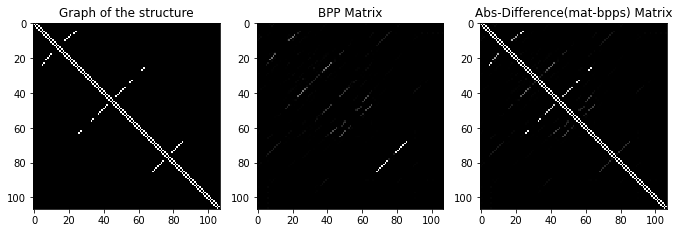

Abs-Difference Value :  259.97288937999997


In [11]:
couples = get_couples(structure)
mat = build_matrix(couples, len(structure))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11.35, 5))

im = axes[0].imshow(mat, interpolation='none',cmap='gray')
axes[0].set_title('Graph of the structure')
# axes[0].pcolormesh(adj_mat, )

bpp = np.load(path +f"/bpps/{Select_id}.npy")

im = axes[1].imshow(bpp, interpolation='none',cmap='gray')
axes[1].set_title('BPP Matrix')

im = axes[2].imshow(abs(mat-bpp), interpolation='none',cmap='gray')
axes[2].set_title('Abs-Difference(mat-bpps) Matrix')

plt.show()

print("Abs-Difference Value : ",abs(mat-bpp).sum())

## 2. Loop-Count

In [12]:
print(f"{len(list(bg.stem_iterator()))} stems")
print(f"{len(list(bg.iloop_iterator()))} interior loops")
print(f"{len(list(bg.mloop_iterator()))} multiloops")
print(f"{len(list(bg.hloop_iterator()))} hairpin loops")
print(f"{len(list(bg.floop_iterator()))} fiveprimes")
print(f"{len(list(bg.tloop_iterator()))} threeprimes")

6 stems
3 interior loops
2 multiloops
3 hairpin loops
1 fiveprimes
1 threeprimes


## 3. Iterate over all pairs of connected stems.

In [13]:
list(bg.connected_stem_iterator())

[('s0', 'm0', 's2'),
 ('s5', 'm1', 's2'),
 ('s1', 'i0', 's0'),
 ('s3', 'i1', 's2'),
 ('s3', 'i2', 's4')]

## 4. Elements Present in RNA

In [14]:
stem_elements = list(bg.stem_iterator())
iloop_elements = list(bg.iloop_iterator())
mloop_elements = list(bg.mloop_iterator())
hloop_elements = list(bg.hloop_iterator())
floop_elements = list(bg.floop_iterator())
tloop_elements = list(bg.tloop_iterator())

elements = stem_elements + iloop_elements + mloop_elements + hloop_elements + floop_elements + tloop_elements
print(list(elements))

['s0', 's1', 's2', 's3', 's4', 's5', 'i0', 'i1', 'i2', 'm0', 'm1', 'h0', 'h1', 'h2', 'f0', 't0']


## 5. Element_Length of each element.

In [15]:
list(map(bg.element_length,elements))

[4, 8, 4, 4, 12, 14, 1, 10, 4, 1, 4, 7, 4, 4, 5, 21]

## 6. A list containing the sequence(s) corresponding to the defines

In [16]:
list(map(bg.get_define_seq_str,elements))


[['AG', 'CU'],
 ['CUCU', 'GGAG'],
 ['GG', 'CC'],
 ['GU', 'AC'],
 ['UUCUAG', 'CUGGAA'],
 ['GUUAGAG', 'CUCUAAC'],
 ['', 'A'],
 ['ACUAC', '', 'CCAUA', ''],
 ['AU', '', 'UA', ''],
 ['A'],
 ['AGCA'],
 ['AAUAACA'],
 ['GUAA'],
 ['UUCG'],
 ['GGAAA'],
 ['AAAAGAAACAACAACAACAAC']]

## 7. Create a minimum spanning tree from this BulgeGraph. This is useful

In [17]:
print(bg.get_mst())

{'t0', 'm0', 's1', 's0', 's4', 'm1', 'i0', 's3', 's5', 'i2', 'h2', 'h0', 'i1', 's2', 'h1', 'f0'}


## 8. Get the minimum and maximum base pair distance between 2 elements

In [18]:
# Example
bg.min_max_bp_distance('s1','s0')

(1.0, 6.0)

In [19]:
min_sum = 0
max_sum = 0
for e1 in stem_elements:
    for e2 in iloop_elements:
        min_dis,max_dis = bg.min_max_bp_distance(e1,e2)
        min_sum += min_dis
        max_sum += max_dis
print("Sum of Min and Max Distances between stem and iloop elements:",min_sum,max_sum)
min_norm_distance = min_sum/(len(stem_elements)+len(iloop_elements))
max_norm_distance = max_sum/(len(stem_elements)+len(iloop_elements))
print("Normalised Min and Max Distances between stem and iloop elements:",min_norm_distance,max_norm_distance)

Sum of Min and Max Distances between stem and iloop elements: 116.0 219.0
Normalised Min and Max Distances between stem and iloop elements: 12.88888888888889 24.333333333333332


In [20]:
distance = 0
for e1 in stem_elements:
    for e2 in iloop_elements:
        distance += bg.ss_distance(e1,e2)
norm_distance = distance/(len(stem_elements)+len(iloop_elements))
print("norm_distance between stem and iloop elements:",norm_distance)

norm_distance between stem and iloop elements: 12.88888888888889


## 9. Simple MFE prediction for a given sequence

In [21]:
# compute minimum free energy (MFE) and corresponding structure
(structure, mfe) = RNA.fold(Sequence)

print('Sequence : ',Sequence)
print('structure : ', structure)
print("MFE(Minimum Free energy) : ",mfe)

Sequence :  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC
structure :  .....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................
MFE(Minimum Free energy) :  -18.899999618530273


In [22]:
seq = Sequence
# create fold_compound data structure (required for all subsequently applied  algorithms)
fc = RNA.fold_compound(seq)
# compute MFE and MFE structure
(mfe_struct, mfe) = fc.mfe()
# rescale Boltzmann factors for partition function computation
fc.exp_params_rescale(mfe)
# compute partition function
(pp, pf) = fc.pf()
# compute centroid structure
(centroid_struct, dist) = fc.centroid()
# compute free energy of centroid structure
centroid_en = fc.eval_structure(centroid_struct)
# compute MEA structure
(MEA_struct, MEA) = fc.MEA()
# compute free energy of MEA structure
MEA_en = fc.eval_structure(MEA_struct)
# print everything like RNAfold -p --MEA
print("Original Sequence: ",Sequence)
print("Original structure: ",structure)
print(f"MFE Structure : {mfe_struct} ,\nMFE : [{mfe}] ")
print(f"centroid structure Structure : {centroid_struct} ,\nCFE : [{centroid_en}] ")
print(f"MEA Structure : {MEA_struct} ,\nMEA : [{MEA_en}] ")

Original Sequence:  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC
Original structure:  .....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................
MFE Structure : .....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....)))))))..................... ,
MFE : [-18.899999618530273] 
centroid structure Structure : .......((((.......))))..............................................(((((((....)))))))..................... ,
CFE : [-10.399999618530273] 
MEA Structure : .....((((((.......)))).)).((.........((((((....)))))).........))....(((((((....)))))))..................... ,
MEA : [-18.299999237060547] 


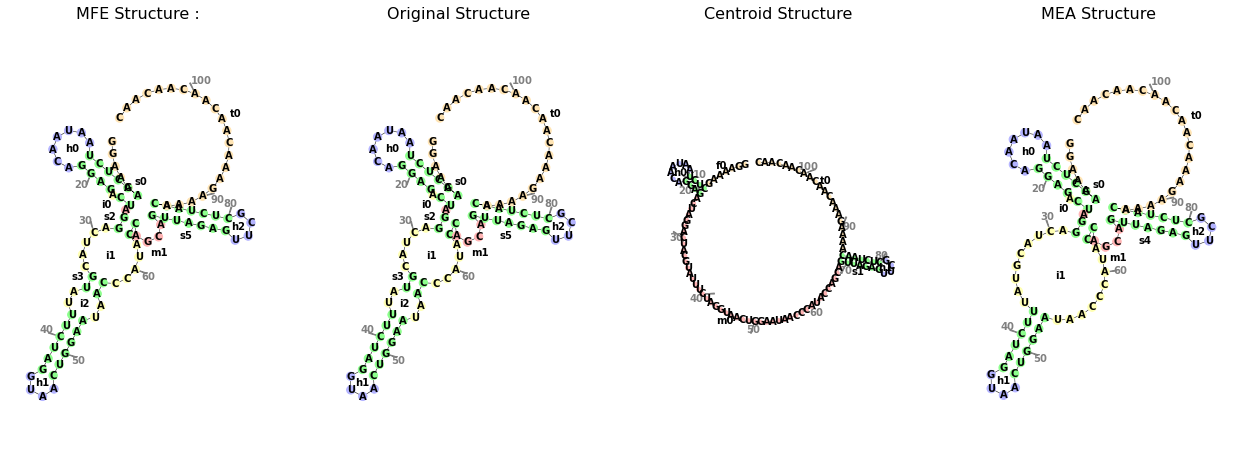

In [23]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (22, 8))
bg1, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + Sequence + '\n' + mfe_struct)
fvm.plot_rna(bg1, text_kwargs={"fontweight":"black"}, lighten=0.7,
             backbone_kwargs={"linewidth":0.5},ax=ax2)
ax1.set_title('MFE Structure : ', fontsize=16)


bg2, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + Sequence + '\n' + structure)
fvm.plot_rna(bg2, text_kwargs={"fontweight":"black"}, lighten=0.7,
             backbone_kwargs={"linewidth":0.5},ax=ax1)
ax2.set_title('Original Structure ', fontsize=16)

bg3, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + Sequence + '\n' + centroid_struct)
fvm.plot_rna(bg3, text_kwargs={"fontweight":"black"}, lighten=0.7,
             backbone_kwargs={"linewidth":0.5},ax=ax3)
ax3.set_title('Centroid Structure ', fontsize=16)

bg4, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + Sequence + '\n' + MEA_struct)
fvm.plot_rna(bg4, text_kwargs={"fontweight":"black"}, lighten=0.7,
             backbone_kwargs={"linewidth":0.5},ax=ax4)
ax4.set_title('MEA Structure ', fontsize=16)

plt.show()

#### [https://www.tbi.univie.ac.at/RNA/ViennaRNA/doc/html/helloworld_swig.html#helloworld_python](https://www.tbi.univie.ac.at/RNA/ViennaRNA/doc/html/helloworld_swig.html#helloworld_python)

## Loop-type (Non Sequencial) Probablity

In [24]:
def loop_count(row):
    Sequence = row["sequence"]
    structure = row["structure"]
    len_ = row["seq_length"]
    bg, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + Sequence + '\n' + structure)
    return [len(list(bg.stem_iterator()))/len_, len(list(bg.iloop_iterator()))/len_, 
            len(list(bg.mloop_iterator()))/len_, len(list(bg.hloop_iterator()))/len_, 
            len(list(bg.floop_iterator()))/len_, len(list(bg.tloop_iterator()))/len_]

In [25]:
loops_name = ['stems','interior_loops', 'multiloops', 'hairpin loops', 'fiveprimes','threeprimes']
train_df[loops_name] = train_df.apply(loop_count, axis=1,result_type="expand")
test_df[loops_name] = test_df.apply(loop_count, axis=1,result_type="expand")
train_df[['id']+loops_name].head()

,id,stems,interior_loops,multiloops,hairpin loops,fiveprimes,threeprimes
0,id_001f94081,0.056075,0.028037,0.018692,0.028037,0.009346,0.009346
1,id_0049f53ba,0.037383,0.009346,0.018692,0.028037,0.009346,0.009346
2,id_006f36f57,0.056075,0.018692,0.037383,0.028037,0.009346,0.009346
3,id_0082d463b,0.046729,0.018692,0.018692,0.028037,0.009346,0.009346
4,id_0087940f4,0.046729,0.028037,0.009346,0.018692,0.009346,0.009346


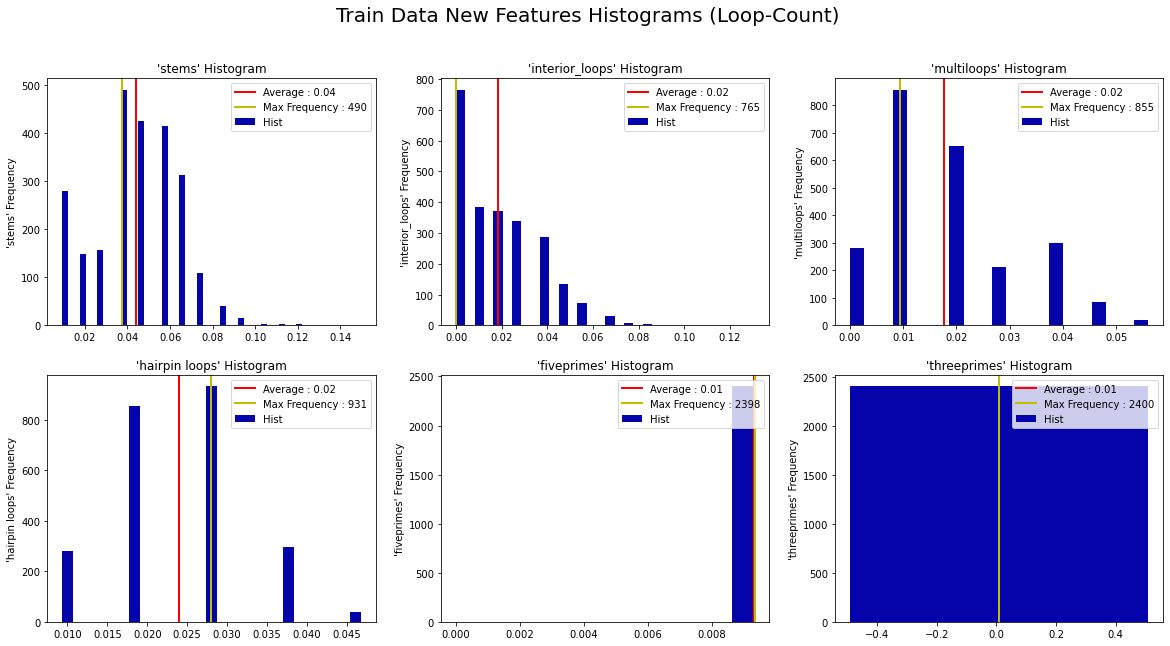

In [26]:
fig, _ax = plt.subplots(nrows=2,ncols=3,figsize=(20,10))
fig.suptitle("Train Data New Features Histograms (Loop-Count)", fontsize=20,)
for i,_ax in enumerate(_ax.ravel()):
    mean_value = train_df[loops_name[i]].mean()
    max_value_index,max_value = Counter(train_df[loops_name[i]]).most_common(1)[0]
    _ax.hist(x=train_df[loops_name[i]],bins='auto', color='#0504aa', alpha=1, rwidth=1)
    _ax.set(ylabel=f"'{loops_name[i]}' Frequency", title= f"'{loops_name[i]}' Histogram")
    _ax.axvline(x=mean_value, color='r', label= 'Average',linewidth=2)
    _ax.axvline(x=max_value_index, color='y', label= 'Max',linewidth=2)
    _ax.legend([f"Average : {mean_value:0.2f}",f"Max Frequency : {max_value}", "Hist"], loc ="upper right")
plt.show()

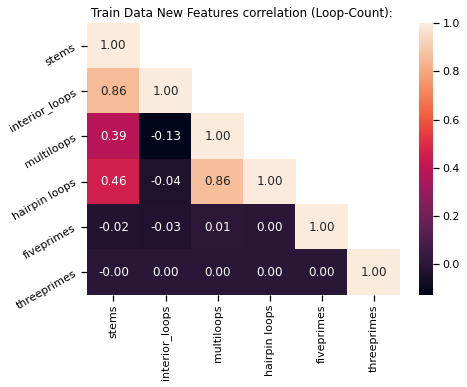

In [27]:
# Train Data New Features correlation(Loop Count)
corr = train_df[loops_name].corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(7,5))
plt.title("Train Data New Features correlation (Loop-Count): ")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

* Loop Count Features are not highly correlated so it is good for us

## process_inputs_2 : [here](https://www.kaggle.com/kank2130/covax-gru-lstm)

In [28]:
def process_inputs_2(df):
    df1 = df.copy()
    df2 = df.copy()
    df3 = df.copy()
    df4 = df.copy()
    df5 = df.copy()
    from collections import Counter as count
    bases = []
    for j in range(len(df1)):
        counts = dict(count(df1.iloc[j]['sequence']))
        bases.append((
            counts['A'] / df1.iloc[j]['seq_length'],
            counts['G'] / df1.iloc[j]['seq_length'],
            counts['C'] / df1.iloc[j]['seq_length'],
            counts['U'] / df1.iloc[j]['seq_length']
        ))

    bases = pd.DataFrame(bases, columns=['A_percent', 'G_percent', 'C_percent', 'U_percent'])
    del df1
    print("Done : ['A_percent', 'G_percent', 'C_percent', 'U_percent']")
    
    pairs = []
    all_partners = []
    for j in range(len(df2)):
        partners = [-1 for i in range(130)]
        pairs_dict = {}
        queue = []
        for i in range(0, len(df2.iloc[j]['structure'])):
            if df2.iloc[j]['structure'][i] == '(':
                queue.append(i)
            if df2.iloc[j]['structure'][i] == ')':
                first = queue.pop()
                try:
                    pairs_dict[(df2.iloc[j]['sequence'][first], df2.iloc[j]['sequence'][i])] += 1
                except:
                    pairs_dict[(df2.iloc[j]['sequence'][first], df2.iloc[j]['sequence'][i])] = 1

                partners[first] = i
                partners[i] = first

        all_partners.append(partners)

        pairs_num = 0
        pairs_unique = [('U', 'G'), ('C', 'G'), ('U', 'A'), ('G', 'C'), ('A', 'U'), ('G', 'U')]
        for item in pairs_dict:
            pairs_num += pairs_dict[item]
        add_tuple = list()
        for item in pairs_unique:
            try:
                add_tuple.append(pairs_dict[item]/pairs_num)
            except:
                add_tuple.append(0)
        pairs.append(add_tuple)

    pairs = pd.DataFrame(pairs, columns=['U-G', 'C-G', 'U-A', 'G-C', 'A-U', 'G-U'])
    del df2
    print("Done : ['U-G', 'C-G', 'U-A', 'G-C', 'A-U', 'G-U']")
    
    pairs_rate = []
    for j in range(len(df3)):
        res = dict(count(df3.iloc[j]['structure']))
        pairs_rate.append(res['('] / (df3.iloc[j]['seq_length']/2))

    pairs_rate = pd.DataFrame(pairs_rate, columns=['pairs_rate'])
    del df3
    
    loops = []
    for j in range(len(df4)):
        counts = dict(count(df4.iloc[j]['predicted_loop_type']))
        available = ['E', 'S', 'H', 'B', 'X', 'I', 'M']
        row = []
        for item in available:
            try:
                row.append(counts[item] / df4.iloc[j]['seq_length'])
            except:
                row.append(0)
        loops.append(row)

    loops = pd.DataFrame(loops, columns=available)
    del df4
    print("Done : ['E', 'S', 'H', 'B', 'X', 'I', 'M']")
    
    return pd.concat([df5, bases, pairs, loops, pairs_rate], axis=1)

In [29]:
# ['A_percent', 'G_percent', 'C_percent', 'U_percent']
# ['U-G', 'C-G', 'U-A', 'G-C', 'A-U', 'G-U']
# ['pairs_rate']
# ['E', 'S', 'H', 'B', 'X', 'I', 'M']

train_df = process_inputs_2(train_df)
train_df.head()

Done : ['A_percent', 'G_percent', 'C_percent', 'U_percent']
Done : ['U-G', 'C-G', 'U-A', 'G-C', 'A-U', 'G-U']
Done : ['E', 'S', 'H', 'B', 'X', 'I', 'M']


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,...,A-U,G-U,E,S,H,B,X,I,M,pairs_rate
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...",...,0.173913,0.000000,0.242991,0.429907,0.140187,0.009346,0.046729,0.130841,0.000000,0.429907
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...",...,0.121212,0.060606,0.242991,0.616822,0.102804,0.009346,0.000000,0.000000,0.028037,0.616822
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...",...,0.125000,0.125000,0.242991,0.448598,0.140187,0.000000,0.009346,0.112150,0.046729,0.448598
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...",...,0.031250,0.062500,0.252336,0.598131,0.130841,0.018692,0.000000,0.000000,0.000000,0.598131
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...",...,0.542857,0.000000,0.242991,0.654206,0.074766,0.028037,0.000000,0.000000,0.000000,0.654206


In [30]:
test_df = process_inputs_2(test_df)
test_df.head()

Done : ['A_percent', 'G_percent', 'C_percent', 'U_percent']
Done : ['U-G', 'C-G', 'U-A', 'G-C', 'A-U', 'G-U']
Done : ['E', 'S', 'H', 'B', 'X', 'I', 'M']


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored,stems,interior_loops,multiloops,...,A-U,G-U,E,S,H,B,X,I,M,pairs_rate
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68,0.065421,0.028037,0.037383,...,0.233333,0.033333,0.252336,0.560748,0.112150,0.065421,0.009346,0.000000,0.000000,0.560748
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91,0.053846,0.023077,0.030769,...,0.100000,0.000000,0.200000,0.461538,0.107692,0.000000,0.030769,0.161538,0.038462,0.461538
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68,0.074766,0.056075,0.009346,...,0.136364,0.000000,0.299065,0.411215,0.065421,0.000000,0.056075,0.168224,0.000000,0.411215
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68,0.046729,0.018692,0.018692,...,0.178571,0.035714,0.252336,0.523364,0.112150,0.000000,0.000000,0.056075,0.056075,0.523364
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91,0.015385,0.000000,0.007692,...,0.041667,0.208333,0.200000,0.738462,0.061538,0.000000,0.000000,0.000000,0.000000,0.738462


In [31]:
ns_columns = ['A_percent','G_percent', 'C_percent', 'U_percent', 
            'U-G', 'C-G', 'U-A', 'G-C','A-U', 'G-U', 'E', 'S', 
            'H', 'B', 'X', 'I', 'M', 'pairs_rate'] + loops_name

def add_axis(row):
    s_len = row[1]
    val = row[0]
    return np.array([val]*int(s_len)).ravel()

for c in ns_columns:
    print(c)
    train_df[c] = train_df[[c,"seq_length"]].apply(add_axis,axis=1)
    test_df[c] = test_df[[c,"seq_length"]].apply(add_axis,axis=1)

A_percent
G_percent
C_percent
U_percent
U-G
C-G
U-A
G-C
A-U
G-U
E
S
H
B
X
I
M
pairs_rate
stems
interior_loops
multiloops
hairpin loops
fiveprimes
threeprimes


In [32]:
train_df[ns_columns].head()

,A_percent,G_percent,C_percent,U_percent,U-G,C-G,U-A,G-C,A-U,G-U,...,X,I,M,pairs_rate,stems,interior_loops,multiloops,hairpin loops,fiveprimes,threeprimes
0,"[0.4205607476635514, 0.4205607476635514, 0.420...","[0.17757009345794392, 0.17757009345794392, 0.1...","[0.21495327102803738, 0.21495327102803738, 0.2...","[0.18691588785046728, 0.18691588785046728, 0.1...","[0.08695652173913043, 0.08695652173913043, 0.0...","[0.13043478260869565, 0.13043478260869565, 0.1...","[0.2608695652173913, 0.2608695652173913, 0.260...","[0.34782608695652173, 0.34782608695652173, 0.3...","[0.17391304347826086, 0.17391304347826086, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.04672897196261682, 0.04672897196261682, 0.0...","[0.1308411214953271, 0.1308411214953271, 0.130...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.42990654205607476, 0.42990654205607476, 0.4...","[0.056074766355140186, 0.056074766355140186, 0...","[0.028037383177570093, 0.028037383177570093, 0...","[0.018691588785046728, 0.018691588785046728, 0...","[0.028037383177570093, 0.028037383177570093, 0...","[0.009345794392523364, 0.009345794392523364, 0...","[0.009345794392523364, 0.009345794392523364, 0..."
1,"[0.2336448598130841, 0.2336448598130841, 0.233...","[0.308411214953271, 0.308411214953271, 0.30841...","[0.29906542056074764, 0.29906542056074764, 0.2...","[0.1588785046728972, 0.1588785046728972, 0.158...","[0.030303030303030304, 0.030303030303030304, 0...","[0.36363636363636365, 0.36363636363636365, 0.3...","[0.030303030303030304, 0.030303030303030304, 0...","[0.3939393939393939, 0.3939393939393939, 0.393...","[0.12121212121212122, 0.12121212121212122, 0.1...","[0.06060606060606061, 0.06060606060606061, 0.0...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.028037383177570093, 0.028037383177570093, 0...","[0.616822429906542, 0.616822429906542, 0.61682...","[0.037383177570093455, 0.037383177570093455, 0...","[0.009345794392523364, 0.009345794392523364, 0...","[0.018691588785046728, 0.018691588785046728, 0...","[0.028037383177570093, 0.028037383177570093, 0...","[0.009345794392523364, 0.009345794392523364, 0...","[0.009345794392523364, 0.009345794392523364, 0..."
2,"[0.40186915887850466, 0.40186915887850466, 0.4...","[0.22429906542056074, 0.22429906542056074, 0.2...","[0.18691588785046728, 0.18691588785046728, 0.1...","[0.18691588785046728, 0.18691588785046728, 0.1...","[0.041666666666666664, 0.041666666666666664, 0...","[0.20833333333333334, 0.20833333333333334, 0.2...","[0.20833333333333334, 0.20833333333333334, 0.2...","[0.2916666666666667, 0.2916666666666667, 0.291...","[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...","[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",...,"[0.009345794392523364, 0.009345794392523364, 0...","[0.11214953271028037, 0.11214953271028037, 0.1...","[0.04672897196261682, 0.04672897196261682, 0.0...","[0.4485981308411215, 0.4485981308411215, 0.448...","[0.056074766355140186, 0.056074766355140186, 0...","[0.018691588785046728, 0.018691588785046728, 0...","[0.037383177570093455, 0.037383177570093455, 0...","[0.028037383177570093, 0.028037383177570093, 0...","[0.009345794392523364, 0.009345794392523364, 0...","[0.009345794392523364, 0.009345794392523364, 0..."
3,"[0.2616822429906542, 0.2616822429906542, 0.261...","[0.32710280373831774, 0.32710280373831774, 0.3...","[0.32710280373831774, 0.32710280373831774, 0.3...","[0.08411214953271028, 0.08411214953271028, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4375, 0.4375, 0.4375, 0.4375, 0.4375, 0.437...","[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.062...","[0.40625, 0.40625, 0.40625, 0.40625, 0.40625, ...","[0.03125, 0.03125, 0.03125, 0.03125, 0.03125, ...","[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.062...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5981308411214953, 0.5

## Sequencial Feature Generation 

## Implementing Sliding Window Features

In [33]:
seq_features = ['sequence','structure','predicted_loop_type']

### Sliding Window Pair Features

In [34]:
def pair_feature(row):
    arr = list(row)
    its = [iter(['_']+arr[:]) ,iter(arr[1:]+['_'])]
    list_touple = list(zip(*its))
    return list(map("".join,list_touple))

In [35]:
print("Sequence: ",Sequence)
print("pair_feature len: ",len(pair_feature(Sequence)))
print("pair_feature : ",(pair_feature(Sequence)))

Sequence:  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC
pair_feature len:  107
pair_feature :  ['_G', 'GA', 'GA', 'AA', 'AA', 'AG', 'AC', 'GU', 'CC', 'UU', 'CA', 'UA', 'AU', 'AA', 'UA', 'AC', 'AA', 'CG', 'AG', 'GA', 'GG', 'AA', 'GC', 'AU', 'CA', 'UG', 'AG', 'GA', 'GC', 'AU', 'CA', 'UC', 'AG', 'CU', 'GA', 'UU', 'AU', 'UU', 'UC', 'UU', 'CA', 'UG', 'AG', 'GU', 'GA', 'UA', 'AC', 'AU', 'CG', 'UG', 'GA', 'GA', 'AU', 'AA', 'UA', 'AC', 'AC', 'CC', 'CA', 'CU', 'AA', 'UC', 'AC', 'CA', 'CG', 'AC', 'GA', 'CG', 'AU', 'GU', 'UA', 'UG', 'AA', 'GG', 'AU', 'GU', 'UC', 'UG', 'CC', 'GU', 'CC', 'UU', 'CA', 'UA', 'AC', 'AA', 'CA', 'AA', 'AA', 'AG', 'AA', 'GA', 'AA', 'AC', 'AA', 'CA', 'AC', 'AA', 'CA', 'AC', 'AA', 'CA', 'AC', 'AA', 'CA', 'AC', 'A_']


In [36]:
# for col in seq_features:
#     train_df['pair_AB_'+col] = train_df[col].apply(pair_feature)
#     test_df['pair_AB_'+col] = test_df[col].apply(pair_feature)
# train_df[seq_features].head()

## Compute MFE,MEA ,Centroid Structure

In [37]:
def compute_structure(seq):
    # create fold_compound data structure (required for all subsequently applied  algorithms)
    fc = RNA.fold_compound(seq)
    # compute MFE and MFE structure
    (mfe_struct, mfe) = fc.mfe()
    # rescale Boltzmann factors for partition function computation
    fc.exp_params_rescale(mfe)
    # compute partition function
    (pp, pf) = fc.pf()
    # compute centroid structure
    (centroid_struct, dist) = fc.centroid()
    # compute MEA structure
    (MEA_struct, MEA) = fc.MEA()
    return mfe_struct,centroid_struct,MEA_struct

In [38]:
for (id_,se,st) in zip(train_df['id'],train_df['sequence'], train_df['structure']):
    mfe_struct,centroid_struct,MEA_struct = compute_structure(se)
    train_df.loc[train_df['id'] == id_,'mfe_structure'] =  mfe_struct
    train_df.loc[train_df['id'] == id_,'centroid_structure'] =  centroid_struct
    train_df.loc[train_df['id'] == id_,'MEA_structure'] =  MEA_struct
    
for (id_,se,st) in zip(test_df['id'],test_df['sequence'], test_df['structure']):
    mfe_struct,centroid_struct,MEA_struct = compute_structure(se)
    test_df.loc[test_df['id'] == id_,'mfe_structure'] =  mfe_struct
    test_df.loc[test_df['id'] == id_,'centroid_structure'] =  centroid_struct
    test_df.loc[test_df['id'] == id_,'MEA_structure'] =  MEA_struct

In [39]:
train_df[['structure','mfe_structure','centroid_structure','MEA_structure']].head()

,structure,mfe_structure,centroid_structure,MEA_structure
0,.....((((((.......)))).)).((.....((..((((((......,.....((((((.......)))).)).((.....((..((((((......,.......((((.......))))...........................,.....((((((.......)))).)).((.........((((((......
1,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...
2,.....((((.((.....((((.(((.....)))..((((......)...,.....((((.((.....((((.(((.....)))..((((......)...,...................................((((......)...,.......((...(.....)...))...........((((......)...
3,......((((((((((((((((......))))))))))))))))((...,......((((((((((((((((......))))))))))))))))((...,......((((((((((((((((......)))))))))))))))).....,......((((((((((((((((......))))))))))))))))((...
4,.....(((((((.((((((((((((.(((((((((....)))))))...,.....(((((((.((((((((((((.(((((((((....)))))))...,......(((((..(((((((((((.((((((((((....)))))))...,.....((((((.((((((((((((.((((((((((....)))))))...


## Loop TypeFeaure Generation (MFE,MEA ,Centroid Structure)

In [40]:
bg, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + Sequence + '\n' + structure)
print(bg.to_element_string(with_numbers=True).split('\n'))
print(predicted_loop_type)

['fffffsssssshhhhhhhssssissmssiiiiissiisssssshhhhssssssiissiiiiissmmmmssssssshhhhsssssssttttttttttttttttttttt', '00000001111000000011110000221111133224444441111444444223311111221111555555522225555555000000000000000000000']
EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHHHSSSSSSIISSIIIIISSXXXXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE


In [41]:
def create_element_string(row):
    
    Sequence = row["sequence"]
    structure = row["structure"]
    bg, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + Sequence + '\n' + structure)
    return bg.to_element_string(with_numbers=True).split('\n')

#  |   Create a string similar to dotbracket notation that identifies what
#  |      type of element is present at each location.
#  |      
#  |      For example the following dotbracket:
#  |      
#  |      ..((..))..
#  |      
#  |      Should yield the following element string:
#  |      
#  |      ffsshhsstt
#  |      
#  |      Indicating that it begins with a fiveprime region, continues with a
#  |      stem, has a hairpin after the stem, the stem continues and it is terminated
#  |      by a threeprime region.
#  |      
#  |      :param with_numbers: show the last digit of the element id in a second line.::
#  |      
#  |                               (((.(((...))))))
#  |      
#  |                           Could result in::
#  |      
#  |                               sssissshhhssssss
#  |                               0000111000111000
#  |      
#  |                           Indicating that the first stem is named 's0', followed by 'i0','
#  |                           s1', 'h0', the second strand of 's1' and the second strand of 's0'

In [42]:
# train_df[['LP_type_value','LP_type_index']] = train_df.apply(create_element_string, axis=1,result_type="expand").head()

### Alternate Method

In [43]:
for (id_,se,st,mfe,cent,mea) in zip(train_df['id'],train_df['sequence'], train_df['structure'],train_df['mfe_structure'], train_df['centroid_structure'], train_df['MEA_structure']):
    
    bg, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + se + '\n' + mfe)
    LP_type_value,LP_type_index = bg.to_element_string(with_numbers=True).split('\n')
    train_df.loc[train_df['id'] == id_,'mfe_predicted_loop_type'] =  LP_type_value
    train_df.loc[train_df['id'] == id_,'mfe_predicted_loop_type_inxex'] =  LP_type_index
    
    bg, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + se + '\n' + cent)
    LP_type_value,LP_type_index = bg.to_element_string(with_numbers=True).split('\n')
    train_df.loc[train_df['id'] == id_,'centroid_predicted_loop_type'] =  LP_type_value
    train_df.loc[train_df['id'] == id_,'centroid_predicted_loop_type_inxex'] =  LP_type_index
    
    bg, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + se + '\n' + mea)
    LP_type_value,LP_type_index = bg.to_element_string(with_numbers=True).split('\n')
    train_df.loc[train_df['id'] == id_,'mea_predicted_loop_type'] =  LP_type_value
    train_df.loc[train_df['id'] == id_,'mea_predicted_loop_type_inxex'] =  LP_type_index
    

In [44]:
train_df[['mfe_predicted_loop_type','mfe_predicted_loop_type_inxex','centroid_predicted_loop_type','centroid_predicted_loop_type_inxex','mea_predicted_loop_type','mea_predicted_loop_type_inxex']].tail()

,mfe_predicted_loop_type,mfe_predicted_loop_type_inxex,centroid_predicted_loop_type,centroid_predicted_loop_type_inxex,mea_predicted_loop_type,mea_predicted_loop_type_inxex
2395,ffffffffssiisshhhhhhssiiissmmmmmmmmmssshhhhhhh...,0000000000001100000011000000000000002221111111...,ffffffffffffffffffffffffffffffffffffssshhhhhhh...,0000000000000000000000000000000000000000000000...,fffffffffffffshhhhhhsmmmmsshhhhssmmmssshhhhhhh...,0000000000000000000000000111111111112222222222...
2396,ffffffffffffffffffffffffffffffffffffffffffffff...,0000000000000000000000000000000000000000000000...,ffffffffffffffffffffffffffffffffffffffffffffff...,0000000000000000000000000000000000000000000000...,ffffffffffffffffffffffffffffffffffffffffffffff...,0000000000000000000000000000000000000000000000...
2397,fffffssssssssssssshhhhssssssssssssssssssssssss...,0000000000000000000000000000000000011111111111...,fffffssssssssssssshhhhssssssssssssssssssssssss...,0000000000000000000000000000000000011111111111...,fffffssssssssssssshhhhssssssssssssssssssssssss...,0000000000000000000000000000000000011111111111...
2398,fffffssssiishhhhsiissssmmmmmmssshhhhsssmmmmmmm...,0000000000010000100000000000022211112221111111...,fffffssssiishhhhsiissssmmmmmmssshhhhsssmmmmmmm...,0000000000010000100000000000022211112221111111...,fffffssssiishhhhsiissssmmmmmmssshhhhsssmmmmmmm...,0000000000010000100000000000022211112221111111...
2399,fffffsssssssssssssssshhhssssissssmsssssssssshh...,0000000000111222233330003333022221444555555511...,fffffsssssssssssssssshhhssssissssmsssssssssshh...,0000000000111222233330003333022221444555555511...,fffffsssssssssssssssshhhssssissssmsssssssssshh...,0000000000111222233330003333022221444555555511...


In [45]:
for (id_,se,st,mfe,cent,mea) in zip(test_df['id'],test_df['sequence'], test_df['structure'],test_df['mfe_structure'], test_df['centroid_structure'], test_df['MEA_structure']):
    
    bg, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + se + '\n' + mfe)
    LP_type_value,LP_type_index = bg.to_element_string(with_numbers=True).split('\n')
    test_df.loc[test_df['id'] == id_,'mfe_predicted_loop_type'] =  LP_type_value
    test_df.loc[test_df['id'] == id_,'mfe_predicted_loop_type_inxex'] =  LP_type_index
    
    bg, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + se + '\n' + cent)
    LP_type_value,LP_type_index = bg.to_element_string(with_numbers=True).split('\n')
    test_df.loc[test_df['id'] == id_,'centroid_predicted_loop_type'] =  LP_type_value
    test_df.loc[test_df['id'] == id_,'centroid_predicted_loop_type_inxex'] =  LP_type_index
    
    bg, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + se + '\n' + mea)
    LP_type_value,LP_type_index = bg.to_element_string(with_numbers=True).split('\n')
    test_df.loc[test_df['id'] == id_,'mea_predicted_loop_type'] =  LP_type_value
    test_df.loc[test_df['id'] == id_,'mea_predicted_loop_type_inxex'] =  LP_type_index

In [46]:
test_df[['mfe_predicted_loop_type','mfe_predicted_loop_type_inxex','centroid_predicted_loop_type','centroid_predicted_loop_type_inxex','mea_predicted_loop_type','mea_predicted_loop_type_inxex']].tail()

,mfe_predicted_loop_type,mfe_predicted_loop_type_inxex,centroid_predicted_loop_type,centroid_predicted_loop_type_inxex,mea_predicted_loop_type,mea_predicted_loop_type_inxex
3629,ffffffffssssssssssssssiiisssssshhhhhhssssssiii...,0000000000000000112222000333333000000333333000...,ffffffffssssssssssssssiiisssssshhhhhhssssssiii...,0000000000000000112222000333333000000333333000...,ffffffffssssssssssssssiiisssssshhhhhhssssssiii...,0000000000000000112222000333333000000333333000...
3630,fffffffsssssmmmssshhhhhhhhhhsssmmmmmmmssshhhhh...,0000000000000001110000000000111111111122211111...,fffffffsssssmmmssshhhhhhhhhhsssmmmmmmmssshhhhh...,0000000000000001110000000000111111111122211111...,fffffffsssssmmmssshhhhhhhhhhsssmmmmmmmssshhhhh...,0000000000000001110000000000111111111122211111...
3631,fffffssssssshhhhssssssssssisssssssssssssssssss...,0000000000000000000000011102222222333333333333...,fffffssssssshhhhssssssssssisssssssssssssssssss...,0000000000000000000000011102222222333333333333...,fffffssssssshhhhssssssssssisssssssssssssssssss...,0000000000000000000000011102222222333333333333...
3632,fffffffsissssisshhhhhhssissssisssssssiiiiiiiii...,0000000001111122000000221111100333333222222222...,fffffffffffffffffffffffffffffffssssssiiiiiiiii...,0000000000000000000000000000000000000000000000...,fffffffffffffffffffffffffffffffssssssiiiiiiiii...,0000000000000000000000000000000000000000000000...
3633,fffffffsssiissssiiiisssssisssssssiiissiisssssh...,0000000000001111111122222233333333334444555550...,fffffffsssiissssiiiisssssisssssssiiissiisssssh...,0000000000001111111122222233333333334444555550...,fffffffsssiissssiiiisssssisssssssiiissiisssssh...,0000000000001111111122222233333333334444555550...


## BPPS Sequence Feature

In [47]:
def build_matrix(couples, size):
    mat = np.zeros((size, size))
    
    for i in range(size):  # neigbouring bases are linked as well
        if i < size - 1:
            mat[i, i + 1] = 1
        if i > 0:
            mat[i, i - 1] = 1
    
    for i, j in couples:
        mat[i, j] = 1
        mat[j, i] = 1
        
    return mat

def get_couples(structure):
    """
    For each closing parenthesis, I find the matching opening one and store their index in the couples list.
    The assigned list is used to keep track of the assigned opening parenthesis
    """
    opened = [idx for idx, i in enumerate(structure) if i == '(']
    closed = [idx for idx, i in enumerate(structure) if i == ')']

    assert len(opened) == len(closed)


    assigned = []
    couples = []

    for close_idx in closed:
        for open_idx in opened:
            if open_idx < close_idx:
                if open_idx not in assigned:
                    candidate = open_idx
            else:
                break
        assigned.append(candidate)
        couples.append([candidate, close_idx])
        
    assert len(couples) == len(opened)
    
    return couples

In [48]:
def BPPS_Mat(row):
    structure = row["structure"]
    couples = get_couples(structure)
    mat = build_matrix(couples, len(structure))
    Select_id = row['id']
    bpp = np.load(path +f"/bpps/{Select_id}.npy")
    BPPS_Mat_min = np.min(mat-bpp,axis=0)
    BPPS_Mat_average = np.average(mat-bpp,axis=0)
    BPPS_Max = np.max(bpp,axis=0)
    
    return [list(BPPS_Mat_min),list(BPPS_Mat_average), 
            list(BPPS_Max)]

In [49]:
list_cols = ['BPPS_Mat_min','BPPS_Mat_average','BPPS_Max']

In [50]:
# train_df[list_cols] = train_df.apply(BPPS_Mat, axis=1,result_type="expand")
# test_df[list_cols] = test_df.apply(BPPS_Mat, axis=1,result_type="expand")

### checking

In [51]:
# exploded = [train_df[col].explode() for col in list_cols]
# train_expanded = pd.DataFrame(dict(zip(list_cols, exploded)))
# train_expanded.reset_index(drop=True, inplace=True)
# train_expanded[list_cols]  = train_expanded[list_cols].astype(str).astype(float)
# train_expanded.head()

In [52]:
# # Train Data New Features correlation (Loop Count)
# corr = train_expanded.corr()
# sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
# plt.figure(figsize=(7,5))
# plt.title("Train Data New Features correlation (BPPS_Mat_min_row, BPPS_Mat_min_col): ")
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask, 1)] = True
# a = sns.heatmap(corr,mask=mask, annot=True, fmt='.4f')
# rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
# roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

## Pair Map

In [53]:
def mk_pair_map(structure, type='pm'):
    pm = np.full(len(structure), -1, dtype=float)
    pd = np.full(len(structure), -1, dtype=float)
    queue = []
    for i, s in enumerate(structure):
        if s == "(":
            queue.append(i)
        elif s == ")":
            j = queue.pop()
            pm[i] = j/len(structure)
            pm[j] = i/len(structure)
            pd[i] = (i-j)/len(structure)
            pd[j] = (i-j)/len(structure)
    if type == 'pm':
        return pm
    elif type == 'pd':
        return pd

In [54]:
train_df['pair_map'] = train_df.structure.apply(mk_pair_map, type='pm')
test_df['pair_map'] = test_df.structure.apply(mk_pair_map, type='pm')

train_df['pair_distance'] = train_df.structure.apply(mk_pair_map, type='pd')
test_df['pair_distance'] = test_df.structure.apply(mk_pair_map, type='pd')

## Final Train And Test Data

In [55]:
train_df.to_csv('train.csv', index=False)
train_df.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,...,centroid_structure,MEA_structure,mfe_predicted_loop_type,mfe_predicted_loop_type_inxex,centroid_predicted_loop_type,centroid_predicted_loop_type_inxex,mea_predicted_loop_type,mea_predicted_loop_type_inxex,pair_map,pair_distance
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...",...,.......((((.......))))...........................,.....((((((.......)))).)).((.........((((((......,fffffsssssshhhhhhhssssissmssiiiiissiisssssshhh...,0000000111100000001111000022111113322444444111...,fffffffsssshhhhhhhssssmmmmmmmmmmmmmmmmmmmmmmmm...,0000000000000000000000000000000000000000000000...,fffffsssssshhhhhhhssssissmssiiiiiiiiisssssshhh...,0000000111100000001111000022111111111333333111...,"[-1.0, -1.0, -1.0, -1.0, -1.0, 0.2242990654205...","[-1.0, -1.0, -1.0, -1.0, -1.0, 0.1775700934579..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...",...,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,fffffssssssssssssssssssssssshhhhssssssssssisss...,0000000000000000001111111111000011111111110000...,fffffssssssssssssssssssssssshhhhssssssssssisss...,0000000000000000001111111111000011111111110000...,fffffssssssssssssssssssssssshhhhssssssssssisss...,0000000000000000001111111111000011111111110000...,"[-1.0, -1.0, -1.0, -1.0, -1.0, 0.5140186915887...","[-1.0, -1.0, -1.0, -1.0, -1.0, 0.4672897196261..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...",...,...................................((((......)...,.......((...(.....)...))...........((((......)...,fffffssssissiiiiissssmssshhhhhsssmmsssshhhhhhs...,0000000000111111122220333000003331144441111114...,fffffffffffffffffffffffffffffffffffsssshhhhhhs...,0000000000000000000000000000000000000000000000...,fffffffssiiishhhhhsiiissmmmmmmmmmmmsssshhhhhhs...,0000000000001000001000000000000000022221111112...,"[-1.0, -1.0, -1.0, -1.0, -1.0, 0.6168224299065...","[-1.0, -1.0, -1.0, -1.0, -1.0, 0.5700934579439..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...",...,......((((((((((((((((......)))))))))))))))).....,......((((((((((((((((......))))))))))))))))((...,ffffffsssssssssssssssshhhhhhssssssssssssssssss...,0000000000000000000000000000000000000000000011...,ffffffsssssssssssssssshhhhhhssssssssssssssssmm...,0000000000000000000000000000000000000000000000...,ffffffsssssssssssssssshhhhhhssssssssssssssssss...,0000000000000000000000000000000000000000000011...,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.4018691...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.3457943..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...",...,......(((((..(((((((((((.((((((((((....)))))))...,.....((((((.((((((((((((.((((((((((....)))))))...,fffffsssssssissssssssssssissssssssshhhhsssssss...,0000000000000111111222222133333333300003333333...,ffffffsssssiisssssssssssisssssssssshhhhsssssss...,0000000000000111112222221333333333300003333333...,fffffssssssissssssssssssisssssssssshhhhsssssss...,0000000000001111112222221333333333300003333333...,"[-1.0, -1.0, -1.0, -1.0, -1.0, 0.6261682242990.

In [56]:
train_df.columns

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C', 'stems', 'interior_loops',
       'multiloops', 'hairpin loops', 'fiveprimes', 'threeprimes', 'A_percent',
       'G_percent', 'C_percent', 'U_percent', 'U-G', 'C-G', 'U-A', 'G-C',
       'A-U', 'G-U', 'E', 'S', 'H', 'B', 'X', 'I', 'M', 'pairs_rate',
       'mfe_structure', 'centroid_structure', 'MEA_structure',
       'mfe_predicted_loop_type', 'mfe_predicted_loop_type_inxex',
       'centroid_predicted_loop_type', 'centroid_predicted_loop_type_inxex',
       'mea_predicted_loop_type', 'mea_predicted_loop_type_inxex', 'pair_map',
       'pair_distance'],
      dtype='object')

In [57]:
test_df.columns

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'seq_length', 'seq_scored', 'stems', 'interior_loops', 'multiloops',
       'hairpin loops', 'fiveprimes', 'threeprimes', 'A_percent', 'G_percent',
       'C_percent', 'U_percent', 'U-G', 'C-G', 'U-A', 'G-C', 'A-U', 'G-U', 'E',
       'S', 'H', 'B', 'X', 'I', 'M', 'pairs_rate', 'mfe_structure',
       'centroid_structure', 'MEA_structure', 'mfe_predicted_loop_type',
       'mfe_predicted_loop_type_inxex', 'centroid_predicted_loop_type',
       'centroid_predicted_loop_type_inxex', 'mea_predicted_loop_type',
       'mea_predicted_loop_type_inxex', 'pair_map', 'pair_distance'],
      dtype='object')

In [58]:
test_df.to_csv('test.csv', index=False)
test_df.head()

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored,stems,interior_loops,multiloops,...,centroid_structure,MEA_structure,mfe_predicted_loop_type,mfe_predicted_loop_type_inxex,centroid_predicted_loop_type,centroid_predicted_loop_type_inxex,mea_predicted_loop_type,mea_predicted_loop_type_inxex,pair_map,pair_distance
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68,"[0.06542056074766354, 0.06542056074766354, 0.0...","[0.028037383177570093, 0.028037383177570093, 0...","[0.037383177570093455, 0.037383177570093455, 0...",...,.........((((.((.(((((.....)))))))....(((((......,.........(((((((.(((((.....)))))))..(((((((......,ffffffssssssssssissssshhhhhsssssssssssssssshhh...,0000000001111222033333000003333322244455555111...,fffffffffssssmssissssshhhhhsssssssmmmmssssshhh...,0000000000000011022222000002222211111133333111...,fffffffffsssssssissssshhhhhsssssssmmssssssshhh...,0000000000000011022222000002222211113344444111...,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.6168224...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.5607476..."
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91,"[0.05384615384615385, 0.05384615384615385, 0.0...","[0.023076923076923078, 0.023076923076923078, 0...","[0.03076923076923077, 0.03076923076923077, 0.0...",...,.....((((..((((((...(((((.....((((....)))).......,.....((((..((((((...(((((.....((((....)))).......,fffffssssiissssssiiisssssiiiiisssshhhhssssiiii...,0000000000011122211133333222224444000044442222...,fffffssssiissssssiiisssssiiiiisssshhhhssssiiii...,0000000000011122211133333222224444000044442222...,fffffssssiissssssiiisssssiiiiisssshhhhssssiiii...,0000000000011122211133333222224444000044442222...,"[-1.0, -1.0, -1.0, -1.0, -1.0, 0.6615384615384...","[-1.0, -1.0, -1.0, -1.0, -1.0, 0.6230769230769..."
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68,"[0.07476635514018691, 0.07476635514018691, 0.0...","[0.056074766355140186, 0.056074766355140186, 0...","[0.009345794392523364, 0.009345794392523364, 0...",...,...........((.(((.(.(..((..((..((((...))))..))...,...........((.(((.(.(..((..((..((((...))))..))...,fffffffffffssisssisisiissiissiisssshhhssssiiss...,0000000000000011112233344445555666600066665555...,fffffffffffssisssisisiissiissiisssshhhssssiiss...,0000000000000011112233344445555666600066665555...,fffffffffffssisssisisiissiissiisssshhhssssiiss...,0000000000000011112233344445555666600066665555...,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68,"[0.04672897196261682, 0.04672897196261682, 0.0...","[0.018691588785046728, 0.018691588785046728, 0...","[0.018691588785046728, 0.018691588785046728, 0...",...,......((((((((((....))))))))))((((((..((.(((.....,......((((((((((....))))))))))((((((..((.(((.....,ffffffsssssssssshhhhssssssssssssssssiississshh...,0000000000000000000000000000001111110022133311...,ffffffsssssssssshhhhssssssssssssssssiississshh...,0000000000000000000000000000001111110022133311...,ffffffsssssssssshhhhssssssssssssssssiississshh...,0000000000000000000000000000001111110022133311...,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.2710280...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.2149532..."
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91,"[0.015384615384615385, 0.015384615384615385, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.007692307692307693, 0.007692307

In [59]:
print(train_df.shape)
print(test_df.shape)

(2400, 54)
(3634, 42)
